In [81]:
import torchvision.transforms as T
import torch.nn.functional as F
import torch.nn as nn
import torch
from torchsummary import summary
from scipy.spatial.distance import hamming, cosine
import numpy as np
import os
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import gc

from tqdm.notebook import tqdm

## Load Data and Helper Functions

In [2]:
def load_image(img_path, img_size):
    '''
    Load an image from disk

    Parameters
    ----------
    img_path : str
        Path to image
    img_size : tuple
        Size of an output image. E.g. (32, 32)

    Returns
    ----------
    img : numpy array
        3-D array array representing the image in RGB format
    '''

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, img_size, cv2.INTER_CUBIC)
    return img

In [3]:
def preprocess(imgs_path, labels_path, img_shape, save_path, pickle_path):
    '''
    Load images and labels from dataset folder

    Parameters
    ----------
    imgs_path : str
        Path to images dataset
    labels_path : str
        Path to labels file
    img_shape : str
        Resultant size of images
    save_path : str
        Directory wherein to store loaded images, labels, and paths
    pickle_path : str
        File in which to store list containing paths to all images

    Returns
    ----------
    images : numpy array
        Array containing all images. Shape: (num_images, *img_shape, 3)
    images : numpy array
        Array containing label for each image. Shape: (num_images)
    '''
    # if already saved, simply load
    if os.path.isfile(save_path + ".npz") and os.path.isfile(pickle_path +
                                                             ".pickle"):
        data = np.load(save_path + ".npz")
        images = data['images']
        labels = data['labels']
        return images, labels

    # create list of classes
    with open(labels_path) as f:
        classes = [c.strip() for c in f.readlines()]
    # assign a label to each class
    class2label = {label: i for i, label in enumerate(classes)}
    files = os.listdir(imgs_path)
    images, labels = np.zeros((len(files), 32, 32, 3)), np.zeros(
        (len(files)))
    image_paths = []

    for i, filename in enumerate(tqdm(files)):
        img_path = os.path.join(imgs_path, filename)
        image_paths.append(img_path)
        label = filename.split('_')[-1].split(".")[0]
        labels[i] = class2label[label]
        images[i] = load_image(img_path, img_shape)

    assert images.shape[
        0] == labels.size, "Number of Images != Number of Labels"

    with open(pickle_path + ".pickle", "wb") as f:
        pickle.dump(image_paths, f)
    with open(save_path + ".npz", "wb") as f:
        np.savez_compressed(f, images=images, labels=labels)
    return images, labels

In [4]:
images, labels = preprocess("cifar/train/", "cifar/labels.txt",
                            "cifar/train_dataset", "cifar/train_paths")

## Model Definition

In [45]:
def conv_block(in_channels,
               out_channels,
               kernel_size,
               pad=True,
               max_pool=True,
               batch_norm=True):
    if pad:
        padding = (kernel_size - 1) // 2
    else:
        padding = 0
    conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding),
        nn.ReLU())
    if max_pool:
        conv.add_module("max_pool", nn.MaxPool2d(2))
    if batch_norm:
        conv.add_module("batch_norm", nn.BatchNorm2d(out_channels))
    return conv


def linear_block(in_features, out_features, final_layer=False):
    block = nn.Sequential(nn.Linear(in_features, out_features))
    if not final_layer:
        block.add_module("dropout", nn.Dropout(0.3))
        block.add_module("activation", nn.ReLU())
    block.add_module("batch_norm", nn.BatchNorm1d(out_features))
    return block


class ImageSearchModel(nn.Module):
    def __init__(self):
        super(ImageSearchModel, self).__init__()
        self.cnn = nn.Sequential(
            conv_block(3, 64, 5, max_pool=False),  # 64x32x32
            conv_block(64, 64, 5),  # 64x16x16
            conv_block(64, 128, 5, max_pool=False),  # 128x16x16
            conv_block(128, 128, 5),  # 128x8x8
            conv_block(128, 256, 5, max_pool=False),  # 256x8x8
            conv_block(256, 256, 5),  # 256x4x4
            conv_block(256, 512, 3, max_pool=False),  # 512x4x4
            conv_block(512, 512, 3),  # 512x2x2
            conv_block(512, 1024, 1, max_pool=False),  # 1024x2x2
            conv_block(1024, 1024, 1),  # 1024x1x1
            conv_block(1024, 2048, 1, max_pool=False)  # 2048x1x1
        )
        self.dense = nn.Sequential(linear_block(2048, 1024),
                                   linear_block(1024, 512),
                                   linear_block(512, 256),
                                   linear_block(256, 128),
                                   linear_block(128, 10, final_layer=True))

    def get_cnn_features(self, image):
        return self.cnn(image)

    def get_dense_features(self, layer_num, image):
        features = self.get_cnn_features(image).view(-1, 2048)
        for i, layer in enumerate(self.dense):
            if i + 1 == layer_num:
                features = layer(features)
                return torch.sigmoid(features)
            else:
                features = layer(features)
        features = torch.sigmoid(features)
        return features

    def forward(self, image):
        cnn_features = self.cnn(image)
        flat = cnn_features.view(-1, 2048)
        logits = self.dense(flat)
        return logits


model = ImageSearchModel()
device = torch.device('cuda')
model.to(device)

## Training

In [15]:
from torch.utils.data import Dataset, DataLoader, random_split


class CIFAR10(Dataset):
    def __init__(self, images, labels):
        '''
        Images: numpy array
            Shape: (B, H, W, C)
            Pytorch uses (B, C, H, W)
        Labels: numpy array
        '''
        self.images = images
        self.labels = labels
        self.transform = T.Compose(
            [T.AutoAugment(T.AutoAugmentPolicy.CIFAR10),
             T.ToTensor()])

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, idx):
        img, label = self.images[idx], self.labels[idx]
        img = Image.fromarray(img.astype('uint8'))
        tensor = self.transform(img)
        return tensor, label


training_data = CIFAR10(images, labels)
train_size = len(training_data) * 8 // 10
train_set, val_set = random_split(
    training_data, [train_size, len(training_data) - train_size],
    generator=torch.Generator().manual_seed(42))
train_dataloader = DataLoader(train_set,
                              batch_size=64,
                              shuffle=True,
                              pin_memory=True)
val_dataloader = DataLoader(val_set, batch_size=128, pin_memory=True)

In [16]:
def accuracy(logits, labels):
    probs = nn.functional.softmax(logits, dim=1)
    preds = torch.argmax(probs, dim=1)
    acc = (labels == preds).sum() / labels.numel() * 100.0
    return acc.item()

In [17]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-3, weight_decay=3e-6)

def train(model, epochs, opt=optimizer):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    previous_val_accuracy = 79.25
    best_epoch = 0
    for epoch in range(epochs):
        train_loss = 0
        current_train_accuracy = 0
        model.train()
        for data in tqdm(train_dataloader, desc="Training", unit="batches"):
            images, labels = data
            images, labels = images.to(
                device=device, dtype=torch.float), labels.to(device=device,
                                                             dtype=torch.float)

            # zero the parameter gradients
            opt.zero_grad()

            outputs = model(images)
            loss = F.cross_entropy(outputs, labels.long())
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
            optimizer.step()
            train_loss += loss.item()
            current_train_accuracy += accuracy(outputs, labels)
        train_losses.append(train_loss)
        mean_train_accuracy = current_train_accuracy / len(train_dataloader)
        train_accuracies.append(mean_train_accuracy)
        # zero the parameter gradients
        opt.zero_grad()
        val_loss = 0
        current_val_accuracy = 0
        model.eval()
        for data in tqdm(val_dataloader, desc="Validation", unit="batches"):
            images, labels = data
            images, labels = images.to(
                device=device, dtype=torch.float), labels.to(device=device,
                                                             dtype=torch.float)
            with torch.no_grad():
                outputs = model(images)
                loss = F.cross_entropy(outputs, labels.long())
            val_loss += loss.item()
            current_val_accuracy += accuracy(outputs, labels)
        val_losses.append(val_loss)
        mean_val_accuracy = current_val_accuracy / len(val_dataloader)
        val_accuracies.append(mean_val_accuracy)
        print(
            f"Epoch {epoch}. Train Loss: {train_loss:.2f}. Train Accuracy: {mean_train_accuracy:.2f}"
        )
        print(
            f"\t Val Loss: {val_loss:.2f}. Val Accuracy: {mean_val_accuracy:.2f}"
        )
        if mean_val_accuracy > previous_val_accuracy:
            print(f"Epoch {epoch}: Best accuracy so far. Saving weights...")
            previous_val_accuracy = mean_val_accuracy
            best_epoch = epoch
            torch.save(model.state_dict(), "classifier_full_change_dropout_position.pt")
    print("Best Epoch: {}\t Best Accuracy: {:.4f}".format(best_epoch, previous_val_accuracy))    

    return train_losses, train_accuracies, val_losses, val_accuracies

In [18]:
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           4,864
              ReLU-2           [-1, 64, 32, 32]               0
       BatchNorm2d-3           [-1, 64, 32, 32]             128
            Conv2d-4           [-1, 64, 32, 32]         102,464
              ReLU-5           [-1, 64, 32, 32]               0
         MaxPool2d-6           [-1, 64, 16, 16]               0
       BatchNorm2d-7           [-1, 64, 16, 16]             128
            Conv2d-8          [-1, 128, 16, 16]         204,928
              ReLU-9          [-1, 128, 16, 16]               0
      BatchNorm2d-10          [-1, 128, 16, 16]             256
           Conv2d-11          [-1, 128, 16, 16]         409,728
             ReLU-12          [-1, 128, 16, 16]               0
        MaxPool2d-13            [-1, 128, 8, 8]               0
      BatchNorm2d-14            [-1, 12

In [19]:
train_losses, train_accuracies, val_losses, val_accuracies = train(model, 100)

Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 0. Train Loss: 1295.51. Train Accuracy: 20.40
	 Val Loss: 163.68. Val Accuracy: 20.59


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 1. Train Loss: 1190.57. Train Accuracy: 27.39
	 Val Loss: 142.00. Val Accuracy: 31.59


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 2. Train Loss: 1086.21. Train Accuracy: 34.59
	 Val Loss: 130.73. Val Accuracy: 36.70


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 3. Train Loss: 969.27. Train Accuracy: 42.72
	 Val Loss: 114.25. Val Accuracy: 48.21


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 4. Train Loss: 846.10. Train Accuracy: 52.45
	 Val Loss: 95.07. Val Accuracy: 57.14


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 5. Train Loss: 741.64. Train Accuracy: 59.32
	 Val Loss: 89.09. Val Accuracy: 61.21


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 6. Train Loss: 666.65. Train Accuracy: 64.08
	 Val Loss: 75.00. Val Accuracy: 67.71


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 7. Train Loss: 612.06. Train Accuracy: 67.90
	 Val Loss: 70.67. Val Accuracy: 69.93


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 8. Train Loss: 556.74. Train Accuracy: 70.93
	 Val Loss: 71.52. Val Accuracy: 70.18


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 9. Train Loss: 521.98. Train Accuracy: 72.79
	 Val Loss: 67.24. Val Accuracy: 71.84


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 10. Train Loss: 490.93. Train Accuracy: 74.61
	 Val Loss: 63.14. Val Accuracy: 73.40


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 11. Train Loss: 461.95. Train Accuracy: 76.33
	 Val Loss: 132.90. Val Accuracy: 74.49


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 12. Train Loss: 437.98. Train Accuracy: 77.68
	 Val Loss: 96.39. Val Accuracy: 73.30


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 13. Train Loss: 415.94. Train Accuracy: 78.94
	 Val Loss: 58.99. Val Accuracy: 75.54


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 14. Train Loss: 392.83. Train Accuracy: 80.03
	 Val Loss: 84.05. Val Accuracy: 75.41


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 15. Train Loss: 378.38. Train Accuracy: 80.77
	 Val Loss: 60.17. Val Accuracy: 75.19


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 16. Train Loss: 364.68. Train Accuracy: 81.55
	 Val Loss: 59.33. Val Accuracy: 76.79


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 17. Train Loss: 349.16. Train Accuracy: 82.46
	 Val Loss: 56.52. Val Accuracy: 76.75


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 18. Train Loss: 333.79. Train Accuracy: 83.33
	 Val Loss: 57.57. Val Accuracy: 76.55


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 19. Train Loss: 321.98. Train Accuracy: 84.00
	 Val Loss: 57.29. Val Accuracy: 76.45


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 20. Train Loss: 310.35. Train Accuracy: 84.67
	 Val Loss: 56.31. Val Accuracy: 77.11


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 21. Train Loss: 303.97. Train Accuracy: 85.19
	 Val Loss: 55.83. Val Accuracy: 77.02


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 22. Train Loss: 293.54. Train Accuracy: 85.53
	 Val Loss: 58.86. Val Accuracy: 77.17


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 23. Train Loss: 286.86. Train Accuracy: 85.83
	 Val Loss: 55.35. Val Accuracy: 77.74


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 24. Train Loss: 277.99. Train Accuracy: 86.26
	 Val Loss: 56.19. Val Accuracy: 77.68


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 25. Train Loss: 273.72. Train Accuracy: 86.67
	 Val Loss: 61.52. Val Accuracy: 77.47


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 26. Train Loss: 270.87. Train Accuracy: 86.85
	 Val Loss: 58.45. Val Accuracy: 77.00


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 27. Train Loss: 257.59. Train Accuracy: 87.47
	 Val Loss: 56.30. Val Accuracy: 77.83


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 28. Train Loss: 255.83. Train Accuracy: 87.64
	 Val Loss: 57.19. Val Accuracy: 77.57


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 29. Train Loss: 253.35. Train Accuracy: 87.69
	 Val Loss: 56.78. Val Accuracy: 78.44


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 30. Train Loss: 247.20. Train Accuracy: 87.85
	 Val Loss: 56.85. Val Accuracy: 77.50


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 31. Train Loss: 236.72. Train Accuracy: 88.54
	 Val Loss: 57.15. Val Accuracy: 78.36


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 32. Train Loss: 240.50. Train Accuracy: 88.28
	 Val Loss: 59.06. Val Accuracy: 77.35


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 33. Train Loss: 243.60. Train Accuracy: 88.28
	 Val Loss: 55.39. Val Accuracy: 78.35


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 34. Train Loss: 230.68. Train Accuracy: 88.98
	 Val Loss: 57.82. Val Accuracy: 78.27


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 35. Train Loss: 231.36. Train Accuracy: 88.81
	 Val Loss: 58.06. Val Accuracy: 77.81


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 36. Train Loss: 221.55. Train Accuracy: 89.42
	 Val Loss: 54.61. Val Accuracy: 78.10


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 37. Train Loss: 224.93. Train Accuracy: 89.22
	 Val Loss: 55.34. Val Accuracy: 78.22


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 38. Train Loss: 216.49. Train Accuracy: 89.55
	 Val Loss: 55.08. Val Accuracy: 78.87


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 39. Train Loss: 219.43. Train Accuracy: 89.25
	 Val Loss: 53.61. Val Accuracy: 79.06


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 40. Train Loss: 210.85. Train Accuracy: 89.80
	 Val Loss: 56.33. Val Accuracy: 77.99


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 41. Train Loss: 213.81. Train Accuracy: 89.77
	 Val Loss: 57.37. Val Accuracy: 77.82


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 42. Train Loss: 215.76. Train Accuracy: 89.64
	 Val Loss: 57.52. Val Accuracy: 77.64


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 43. Train Loss: 207.30. Train Accuracy: 90.09
	 Val Loss: 56.69. Val Accuracy: 78.57


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 44. Train Loss: 207.33. Train Accuracy: 89.99
	 Val Loss: 55.86. Val Accuracy: 78.96


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 45. Train Loss: 205.10. Train Accuracy: 90.15
	 Val Loss: 55.86. Val Accuracy: 78.89


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 46. Train Loss: 206.08. Train Accuracy: 90.12
	 Val Loss: 54.55. Val Accuracy: 78.66


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 47. Train Loss: 200.45. Train Accuracy: 90.34
	 Val Loss: 56.21. Val Accuracy: 78.50


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 48. Train Loss: 205.62. Train Accuracy: 90.19
	 Val Loss: 56.32. Val Accuracy: 79.20


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 49. Train Loss: 197.38. Train Accuracy: 90.71
	 Val Loss: 54.70. Val Accuracy: 78.78


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 50. Train Loss: 200.55. Train Accuracy: 90.44
	 Val Loss: 60.04. Val Accuracy: 77.61


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 51. Train Loss: 194.85. Train Accuracy: 90.60
	 Val Loss: 56.11. Val Accuracy: 79.24


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 52. Train Loss: 192.42. Train Accuracy: 90.69
	 Val Loss: 56.98. Val Accuracy: 78.66


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 53. Train Loss: 191.67. Train Accuracy: 90.76
	 Val Loss: 54.49. Val Accuracy: 79.43
Epoch 53: Best accuracy so far. Saving weights...


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 54. Train Loss: 194.72. Train Accuracy: 90.67
	 Val Loss: 55.79. Val Accuracy: 78.76


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 55. Train Loss: 186.37. Train Accuracy: 91.08
	 Val Loss: 55.94. Val Accuracy: 79.20


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 56. Train Loss: 197.30. Train Accuracy: 90.55
	 Val Loss: 57.73. Val Accuracy: 78.65


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 57. Train Loss: 189.71. Train Accuracy: 91.01
	 Val Loss: 57.99. Val Accuracy: 78.96


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 58. Train Loss: 192.08. Train Accuracy: 90.92
	 Val Loss: 55.87. Val Accuracy: 79.27


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 59. Train Loss: 192.98. Train Accuracy: 90.83
	 Val Loss: 58.81. Val Accuracy: 77.98


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 60. Train Loss: 193.64. Train Accuracy: 90.70
	 Val Loss: 55.51. Val Accuracy: 79.12


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 61. Train Loss: 189.05. Train Accuracy: 90.87
	 Val Loss: 54.59. Val Accuracy: 79.44
Epoch 61: Best accuracy so far. Saving weights...


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 62. Train Loss: 182.61. Train Accuracy: 91.14
	 Val Loss: 59.81. Val Accuracy: 78.68


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 63. Train Loss: 183.68. Train Accuracy: 91.22
	 Val Loss: 56.72. Val Accuracy: 78.66


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 64. Train Loss: 184.29. Train Accuracy: 91.16
	 Val Loss: 59.01. Val Accuracy: 78.23


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 65. Train Loss: 185.30. Train Accuracy: 91.07
	 Val Loss: 57.29. Val Accuracy: 78.41


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 66. Train Loss: 181.25. Train Accuracy: 91.25
	 Val Loss: 55.07. Val Accuracy: 79.50
Epoch 66: Best accuracy so far. Saving weights...


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 67. Train Loss: 181.84. Train Accuracy: 91.11
	 Val Loss: 55.31. Val Accuracy: 79.53
Epoch 67: Best accuracy so far. Saving weights...


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 68. Train Loss: 178.13. Train Accuracy: 91.53
	 Val Loss: 57.17. Val Accuracy: 79.25


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 69. Train Loss: 173.93. Train Accuracy: 91.70
	 Val Loss: 53.95. Val Accuracy: 79.81
Epoch 69: Best accuracy so far. Saving weights...


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 70. Train Loss: 180.07. Train Accuracy: 91.49
	 Val Loss: 52.79. Val Accuracy: 80.04
Epoch 70: Best accuracy so far. Saving weights...


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 71. Train Loss: 175.51. Train Accuracy: 91.52
	 Val Loss: 55.76. Val Accuracy: 79.65


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 72. Train Loss: 175.06. Train Accuracy: 91.62
	 Val Loss: 59.44. Val Accuracy: 78.37


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 73. Train Loss: 177.50. Train Accuracy: 91.48
	 Val Loss: 56.90. Val Accuracy: 79.29


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 74. Train Loss: 175.88. Train Accuracy: 91.66
	 Val Loss: 57.24. Val Accuracy: 79.25


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 75. Train Loss: 174.49. Train Accuracy: 91.72
	 Val Loss: 54.73. Val Accuracy: 79.52


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 76. Train Loss: 174.37. Train Accuracy: 91.84
	 Val Loss: 55.01. Val Accuracy: 79.98


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 77. Train Loss: 171.13. Train Accuracy: 91.67
	 Val Loss: 54.54. Val Accuracy: 79.88


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 78. Train Loss: 173.01. Train Accuracy: 91.80
	 Val Loss: 56.96. Val Accuracy: 79.06


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 79. Train Loss: 171.74. Train Accuracy: 91.79
	 Val Loss: 53.08. Val Accuracy: 80.06
Epoch 79: Best accuracy so far. Saving weights...


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 80. Train Loss: 170.57. Train Accuracy: 91.92
	 Val Loss: 56.74. Val Accuracy: 80.01


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 81. Train Loss: 171.55. Train Accuracy: 91.78
	 Val Loss: 57.98. Val Accuracy: 79.40


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 82. Train Loss: 168.33. Train Accuracy: 91.92
	 Val Loss: 53.67. Val Accuracy: 80.10
Epoch 82: Best accuracy so far. Saving weights...


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 83. Train Loss: 176.45. Train Accuracy: 91.62
	 Val Loss: 59.35. Val Accuracy: 79.52


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 84. Train Loss: 169.50. Train Accuracy: 91.94
	 Val Loss: 55.35. Val Accuracy: 79.48


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 85. Train Loss: 171.81. Train Accuracy: 91.91
	 Val Loss: 56.62. Val Accuracy: 79.60


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 86. Train Loss: 172.27. Train Accuracy: 91.92
	 Val Loss: 55.73. Val Accuracy: 79.22


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 87. Train Loss: 168.73. Train Accuracy: 91.98
	 Val Loss: 54.67. Val Accuracy: 79.86


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 88. Train Loss: 169.67. Train Accuracy: 91.86
	 Val Loss: 53.19. Val Accuracy: 80.46
Epoch 88: Best accuracy so far. Saving weights...


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 89. Train Loss: 170.40. Train Accuracy: 92.01
	 Val Loss: 54.98. Val Accuracy: 79.84


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 90. Train Loss: 166.31. Train Accuracy: 92.21
	 Val Loss: 57.21. Val Accuracy: 78.63


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 91. Train Loss: 170.26. Train Accuracy: 91.81
	 Val Loss: 53.41. Val Accuracy: 79.70


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 92. Train Loss: 165.12. Train Accuracy: 92.22
	 Val Loss: 56.11. Val Accuracy: 78.92


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 93. Train Loss: 163.47. Train Accuracy: 92.15
	 Val Loss: 57.36. Val Accuracy: 79.18


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 94. Train Loss: 165.00. Train Accuracy: 92.12
	 Val Loss: 53.09. Val Accuracy: 80.20


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 95. Train Loss: 164.60. Train Accuracy: 92.23
	 Val Loss: 57.74. Val Accuracy: 79.54


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 96. Train Loss: 163.88. Train Accuracy: 92.21
	 Val Loss: 55.24. Val Accuracy: 79.45


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 97. Train Loss: 167.91. Train Accuracy: 92.00
	 Val Loss: 54.48. Val Accuracy: 80.16


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 98. Train Loss: 163.82. Train Accuracy: 92.21
	 Val Loss: 56.93. Val Accuracy: 79.50


Training:   0%|          | 0/625 [00:00<?, ?batches/s]

Validation:   0%|          | 0/79 [00:00<?, ?batches/s]

Epoch 99. Train Loss: 161.11. Train Accuracy: 92.36
	 Val Loss: 60.72. Val Accuracy: 78.62
Best Epoch: 88	 Best Accuracy: 80.4589


## Inference

In [77]:
model.load_state_dict(torch.load('classifier_full_change_dropout_position.pt'))
model.to(torch.device('cpu'))
model.eval();

In [63]:
with open("cifar/train_paths.pickle", "rb") as f:
    paths = pickle.load(f)

In [102]:
def store_train_vectors(model, images, paths):
    transform = T.ToTensor()
    for i, x in enumerate(tqdm(images)):
        tensor = transform(x).float()
        tensor = torch.unsqueeze(tensor, 0)
        features_512 = model.get_dense_features(2, tensor)
        features_128 = model.get_dense_features(4, tensor)
        features_stack = torch.hstack((features_512, features_128))
        train_vector = features_stack.detach().numpy()

        filename = paths[i].split('/')[-1][:-4]
        with open("vectors/" + filename + ".npy", "wb") as f:
            np.save(f, train_vector)

In [103]:
store_train_vectors(model, images, paths)

  0%|          | 0/50000 [00:00<?, ?it/s]

In [107]:
def infer(model, train_vectors_dir, query_img_path, k=50, distance="hamming"):
    '''
    Load image from query_img_path
    Get feature vector of query
    For all vectors:
        Load a vector from train_vectors_dir
        Compute similarity betweeen query and vector
        Store similarity in array
    Sort similarities array using argsort
    Return indices of top k similar vectors
    '''
    assert distance in (
        "hamming",
        "cosine"), "Invalid Distance Metric! Valid: 'hamming' or 'cosine'"
    query = load_image(query_img_path, (32, 32))
    transform = T.ToTensor()
    tensor = transform(query).unsqueeze(0).float()
    features_512 = model.get_dense_features(2, tensor)
    features_128 = model.get_dense_features(4, tensor)
    features_stack = torch.hstack((features_512, features_128))
    query_vector = features_stack.detach().numpy()
    if distance == "hamming":
        query_vector = np.where(query_vector < 0.5, 0, 1)

    files = os.listdir(train_vectors_dir)
    similarities = np.zeros(len(files))
    for i, filename in enumerate(tqdm(files)):
        vector_path = os.path.join(train_vectors_dir, filename)
        train_vector = np.load(vector_path)
        if distance == "hamming":
            train_vector = np.where(train_vector < 0.5, 0, 1)
            similarities[i] = hamming(train_vector, query_vector)
        else:
            similarities[i] = cosine(train_vector, query_vector)
    indices = np.argsort(similarities)
    if distance == "hamming":
        return indices[:k]
    else:
        return indices[-k::-1]

### Testing

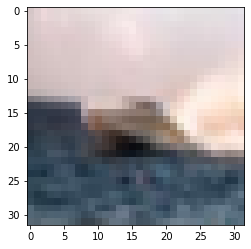

In [115]:
test_img = "cifar/test/265_ship.png"
plt.imshow(load_image(test_img, (32, 32)))

In [116]:
indices = infer(model, "vectors", test_img)

  0%|          | 0/50000 [00:00<?, ?it/s]

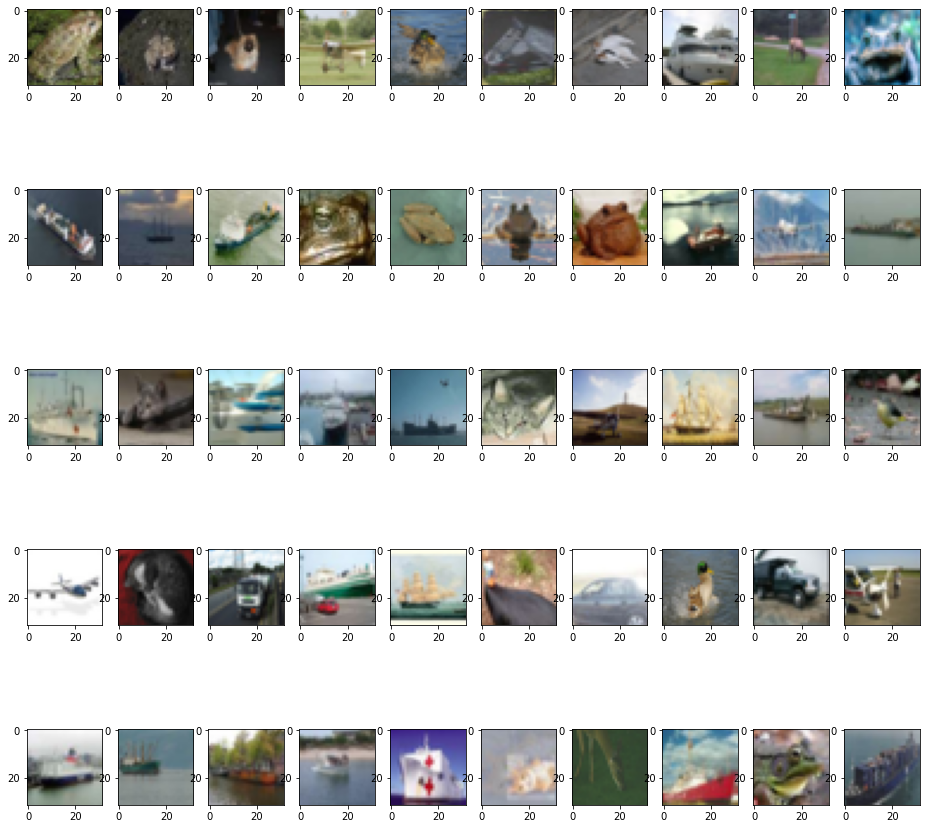

In [117]:
fig = plt.figure(figsize=(16, 16))
cols = 10
rows = 5
for i in range(1, rows * cols + 1):
    img = load_image(paths[indices[i - 1]], (32, 32))
    fig.add_subplot(rows, cols, i)
    plt.imshow(img)
plt.show()